In [36]:
import numpy as np
import scipy
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt 

In [39]:
# parse val. output
nocams = 8
sampval = [None] * nocams
for i in xrange(nocams):
    sampval[i] = []
    lines = [line.rstrip('\n') for line in open('/tmp/ldcam_err_set_sam{:02}.txt'.format(i))]
    #lines = [line.rstrip('\n') for line in open('/tmp/test.txt')]
    nosamples = int(lines[0])
    
    arr = [np.fromstring(x, dtype=float, sep=' ') for x in lines[1::]]
    arr = np.stack(arr)
    sampval[i].append(arr)
arr = np.concatenate(sampval, axis=1)[0,:,:]
print arr.shape

(800, 5)


In [57]:
# Train logistic regressors
from sklearn.linear_model import LogisticRegression
degthresh = 0.5
y_train = 1 - (arr[:,0] < degthresh)
x_train = arr[:,2].reshape(-1, 1)

model = LogisticRegression(class_weight = "balanced", C=1e2)
model.fit(x_train, y_train)
train_acc = model.score(x_train, y_train)
print train_acc

outp_prob = model.predict_proba(x_train)[:,1]
outp = model.predict(x_train)
res = np.vstack(( arr[:,1], outp_prob, outp, y_train)).T
#print res

0.93


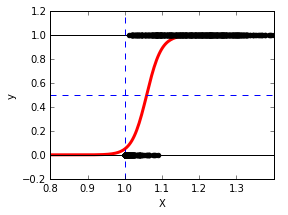

[[ 50.37360521]] [-53.32353039]


In [58]:
#Plot log function for test points 
plt.figure(1, figsize=(4, 3))
plt.scatter(x_train.ravel(), y_train, color='black', zorder=20)

def modellg(xin):
    return 1 / (1 + np.exp(-xin))
def calcloss(xin, model):
    return modellg(xin * model.coef_ + model.intercept_).ravel()    

x_test = np.linspace(0.5, 1.5, 300)
loss = calcloss(x_test, model)

plt.plot(x_test, loss, color='red', linewidth=3)
plt.axhline(y=0, color='k', linestyle='-')
plt.axhline(y=1, color='k', linestyle='-')
plt.axhline(y=0.5, color='b', linestyle='--')
plt.axvline(x=1, color='b', linestyle='--')

plt.ylabel('y')
plt.xlabel('X')
plt.xlim(0.8, 1.4)
plt.show()

print model.coef_,model.intercept_

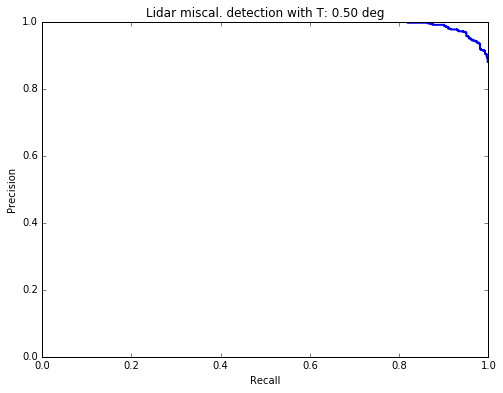

In [59]:
# PLOT log function
plt.figure(1, figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_train, x_train)
plt.step(recall, precision, color='b', linewidth=2)#, alpha=0.2,where='post')
#plt.fill_between(recall, precision, step='post')#, alpha=0.2,color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0.0, 1.0)
plt.title('Lidar miscal. detection with T: {:0.2f} deg'.format(degthresh))
plt.show()

# TODO: plot likelihood of miscal detection VS mis.cal

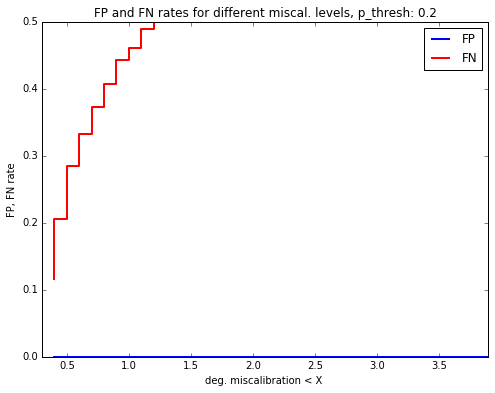

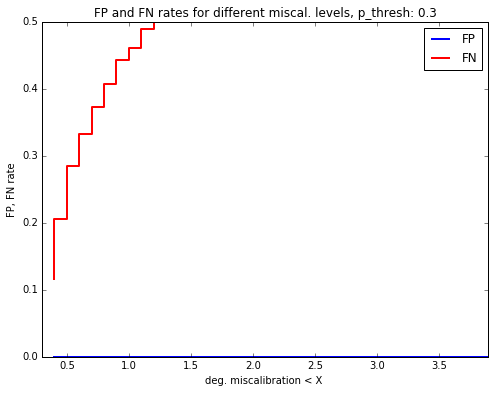

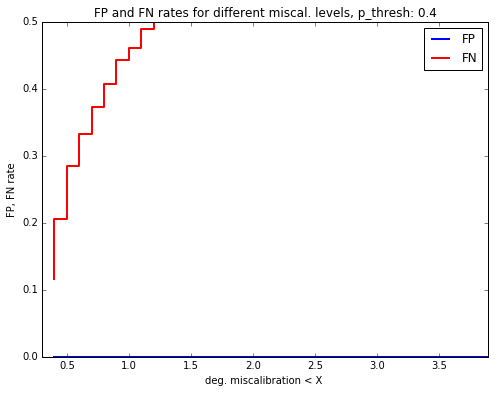

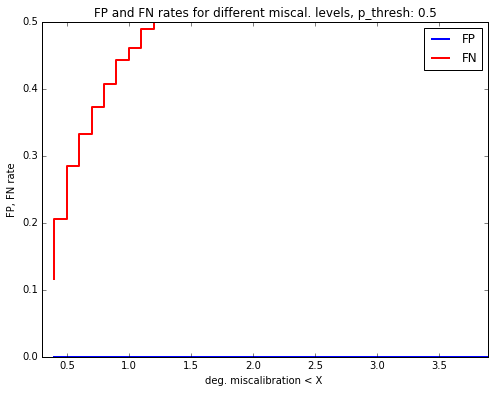

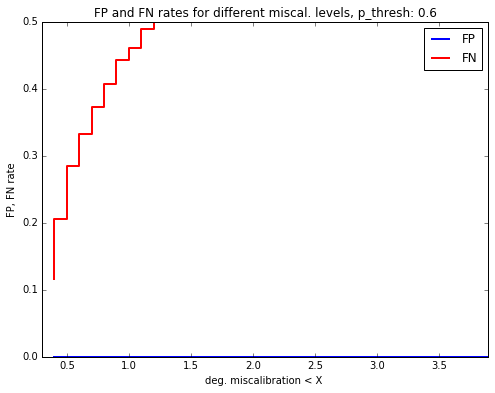

In [56]:
miscalprobthresh_range = [0.2, 0.3, 0.4, 0.5, 0.6]
for miscalprobthresh in miscalprobthresh_range:
    miscal_gt = arr[:,0]>degthresh
    maxcal_range = np.arange(degthresh+0.1,4,0.1)
    miscal_pred = calcloss(arr[:,1], model) > miscalprobthresh # predict    
    maxcal_prob = []
    for maxcal in maxcal_range:
        idx = np.where(arr[:,0] < maxcal)[0] # data with cal error < this
        fp = ((miscal_pred[idx] == True) & (miscal_gt[idx]==False))
        fn = ((miscal_pred[idx] == False) & (miscal_gt[idx]==True))
        maxcal_prob.append(np.array([np.mean(fp), np.mean(fn)]))
    maxcal_prob = np.stack(maxcal_prob)
    #print maxcal_prob

    plt.figure(1, figsize=(8, 6))
    plt.step(maxcal_range, maxcal_prob[:,0], color='b', linewidth=2, label='FP')
    plt.step(maxcal_range, maxcal_prob[:,1], color='r', linewidth=2, label='FN')
    #plt.fill_between(recall, precision, step='post')#, alpha=0.2,color='b')
    plt.xlabel('deg. miscalibration < X ')
    plt.ylabel('FP, FN rate')
    plt.xlim(degthresh, maxcal_range[-1])
    plt.ylim(0, 0.5)
    plt.legend()
    plt.title('FP and FN rates for different miscal. levels, p_thresh: {:}'.format(miscalprobthresh))
    plt.show()